# Training RSTAE

This notebook shows how to train the anomaly detection model.

In [1]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from models import RelationalSTAE
from parameters import RSTAEParameters, TrainingParameters
from datautils import get_morning_data, get_rstae_sequence, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_rstae, compute_anomaly_threshold_rstae, test_model, threshold_anomalies, fill_result_df, test_rstae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc, discrete_fp_delays_loc
import torch.nn as nn
from tqdm import tqdm

import random
import os
import torch_geometric
seed=42
torch_geometric.seed_everything(seed)

/media/vanderbilt/home/zulqarnain/anaconda3/envs/traffic-anomaly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Time Series Sequencing

In [2]:
def sequence_rstae(data, timesteps, hide_anomalies=False):
    sequence = []
    relational_edges, relations = generate_relational_edges(milemarkers=list(range(49)), timesteps=timesteps)
    static_edges = generate_edges(milemarkers=list(range(49)))
    days = data['day']
    anomalies = data['anomaly']
    data_vals = data[['occ', 'speed', 'volume']]
    unix = data['unix_time']
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times[timesteps:])): # skip first 'timesteps'
        data_t = []
        backward_index = range(index-1, index-timesteps-1, -1)
        backward_times = [unique_times[i] for i in backward_index]
        curr_day = np.unique(data[data['unix_time']==backward_times[-1]]['day'])[0]
        contains_anomaly = np.any([np.unique(data[data['unix_time']==i]['anomaly'])[0] for i in backward_times])
        is_curr_day = np.all([np.unique(data[data['unix_time']==i]['day'])[0]==curr_day for i in backward_times])

        if (hide_anomalies and contains_anomaly) or not is_curr_day:
            continue
        
        kept_indices.append(index+timesteps)

        for i in backward_times:
            data_t.append(data[data['unix_time']==i][['occ', 'speed', 'volume']].to_numpy()) # assumes time indices come sequentially, with full data it may not

        node_data = np.concatenate(data_t[::-1])
        pyg_data = Data(x=torch.tensor(node_data, dtype=torch.float32), edge_index=relational_edges, edge_attr=torch.tensor(relations, dtype=torch.long))
        
        # curr_data = data_t[-1]
        curr_data = data_t[0]
        
        curr_graph = Data(x=torch.tensor(curr_data, dtype=torch.float32), edge_index=static_edges)
        sequence.append([pyg_data, curr_graph])

    return sequence, kept_indices

### Loading Hyperparameters

In [3]:
hide_anomalies = False
optimal_hyperparams = load_best_parameters('rstae',hide_anomalies=hide_anomalies)

In [4]:
mse_weights = [1,1,1] # weights for loss function (occupancy, speed, volume)

In [5]:
training_params = TrainingParameters(
    learning_rate=optimal_hyperparams['learning_rate'],
    batch_size=1,
    timesteps=optimal_hyperparams['timesteps'],
    n_epochs=optimal_hyperparams['epochs'],
)

In [6]:
data, test_data, _ = get_full_data()
data = normalize_data(data)
data = label_anomalies(data)
length = len(data.day.unique())
train_length = int(length * 0.8)
val_length = length - train_length
train_days = data.day.unique()[:train_length]
val_days = data.day.unique()[train_length:]

# Use .isin() to filter the DataFrame based on the days
train_data = data[data.day.isin(train_days)]
val_data = data[data.day.isin(val_days)]
train_sequence, kept_train_indices = sequence_rstae(train_data, training_params.timesteps, hide_anomalies=hide_anomalies)
val_sequence, kept_val_indices = sequence_rstae(val_data, training_params.timesteps, hide_anomalies=hide_anomalies)

100%|██████████| 2876/2876 [00:09<00:00, 306.01it/s]


In [7]:
hyperparams = RSTAEParameters(
    num_features=3,
    latent_dim=optimal_hyperparams['latent_dim'],
    gcn_hidden_dim=optimal_hyperparams['gcn_hidden_dim'],
    dropout=optimal_hyperparams['dropout'],
    num_gcn=optimal_hyperparams['num_gcn']
)

In [8]:
# ae = RelationalSTAE(hyperparams)

### Model Training or Loading

In [9]:
using_pretrained = True

In [10]:
if not using_pretrained:
    ae, losses = train_rstae(rstaeparams=hyperparams, trainingparams=training_params, training_data=train_sequence, mse_weights=mse_weights, verbose=True)
    save_model(ae, f'rstae_{hide_anomalies}_{seed}')
else:
    ae = load_model(RelationalSTAE, hyperparams, f'rstae_{hide_anomalies}_{seed}')

In [11]:
if not using_pretrained:
    plt.plot(losses)

### Computing Node-level Anomaly Threshold

In [12]:
thresh = compute_anomaly_threshold_rstae(val_sequence, ae, mse_weights, 'max')

100%|██████████| 2867/2867 [00:06<00:00, 460.03it/s]


### Loading Test Data

In [13]:
_, df_test_data, _ = get_full_data()

In [14]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_rstae(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4796/4796 [00:20<00:00, 231.91it/s]


In [15]:
test_errors, test_recons_speeds, test_true_speeds = test_rstae(test_data, mse_weights, ae)

In [16]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
# crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [17]:
converted_dates_utc = pd.to_datetime(df_test_data.unix_time, unit='s', utc=True)

# Step 2: Convert to US/Central timezone
converted_dates_central = converted_dates_utc.dt.tz_convert('US/Central')
converted_dates_naive = converted_dates_central.dt.tz_localize(None)
df_test_data['Time']=converted_dates_naive

import glob
pattern=sorted(glob.glob('../data/event_data/2023-10-*.csv'))
events=pd.DataFrame()
for i in pattern:
    event=pd.read_csv(i,sep=';')
    events=pd.concat([events,event],axis=0)
events.reset_index(drop=True,inplace=True)
# events['timestamp']=pd.to_datetime(events['event_update_time'],utc=False)
events['Time'] = pd.to_datetime(events['event_update_time'], utc=False)

# To ensure the timestamps are naive (no timezone)
events['Time'] = events['Time'].dt.tz_localize(None).dt.floor('1s').dt.ceil('30s')
events=events[(events['event_update_type'] == 'new') & (events['classification']=='incident')]
events.drop_duplicates(subset=['event_id'],inplace=True)
events=events.sort_values(by='Time').reset_index(drop=True)


array1=np.array(events.milemarker.sort_values().unique())
array2=np.array(df_test_data.milemarker.unique())
def find_closest_or_exact(target, array):
    # Find the indices where the target would fit
    idx = np.searchsorted(array, target)
    
    # Check for exact match
    if idx < len(array) and array[idx] == target:
        return array[idx]  # Exact match
    
    # Find the closest lower value (if it exists)
    lower = array[idx - 1] if idx > 0 else None
    
    # Find the closest higher value (if it exists)
    higher = array[idx] if idx < len(array) else None
    
    return [lower, higher]

# Mapping from array2 to closest values in array1
events['mapped_milemarkers'] = events['milemarker'].apply(lambda x: find_closest_or_exact(x, array2))
events=events.explode('mapped_milemarkers')
# Filter events based on Time in df_test_data
test_events = events[events['Time'].isin(df_test_data['Time'])]

# Ensure 'Time' in test_events is properly converted to pandas.Timestamp
test_events['Time'] = pd.to_datetime(test_events['Time'])

df_test_data['combined'] = df_test_data['Time'].astype(str) + '_' + df_test_data['milemarker'].astype(str)
test_events['combined'] = test_events['Time'].astype(str) + '_' + test_events['mapped_milemarkers'].astype(str)

df_test_data['exists'] = df_test_data['combined'].isin(test_events['combined']).astype(int)
df_test_data['crash_record']=((df_test_data['exists'] == 1) & (df_test_data['crash_record'] == 1)
).astype(int)
crash_reported=df_test_data['crash_record'].to_numpy().reshape(-1,196)[kept_test_indices]
results = discrete_fp_delays_loc(thresh, test_errors, anomaly_labels, crash_reported)
path_results = 'saved_results_loc/rstae/'
if not os.path.exists(path_results):
    os.makedirs(path_results)
results.to_csv(f'{path_results}results_{hide_anomalies}_{seed}.csv', index=False)



/tmp/ipykernel_2427311/4279471951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_data['Time']=converted_dates_naive
/tmp/ipykernel_2427311/4279471951.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_events['Time'] = pd.to_datetime(test_events['Time'])
/tmp/ipykernel_2427311/4279471951.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

Found FPR of 0.009876543209876543 for 0.01
Found FPR of 0.025102880658436213 for 0.025
Found FPR of 0.050205761316872426 for 0.05
Found FPR of 0.09958847736625515 for 0.1
Found FPR of 0.2008230452674897 for 0.2
FPR 1% gives mean delay of -3.642857142857143 +/- 8.931142486963745 with mean. distance of 3.78 +/- 3.874738700867453 while missing 0.30000000000000004%.
FPR 2.5% gives mean delay of -11.571428571428571 +/- 4.593695768803865 with mean. distance of 3.605 +/- 3.603640520362707 while missing 0.30000000000000004%.
FPR 5% gives mean delay of -9.35 +/- 8.631483070712703 with mean. distance of 3.08 +/- 3.21085658353032 while missing 0.0%.
FPR 10% gives mean delay of -10.8 +/- 8.225569889071517 with mean. distance of 2.7562499999999996 +/- 3.1642472939863597 while missing 0.0%.
FPR 20% gives mean delay of -13.95 +/- 1.2134661099511597 with mean. distance of 3.15 +/- 3.057913231818936 while missing 0.0%.


In [18]:
path_results = 'saved_results/rstae/'
results = discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

# Check if the directory exists, and create it if it does not
if not os.path.exists(path_results):
    os.makedirs(path_results)

# Save the results to a CSV file
results.to_csv(f'{path_results}results_{hide_anomalies}_{seed}.csv', index=False)

 22%|██▏       | 224/1000 [00:06<00:23, 33.42it/s]


KeyboardInterrupt: 

In [ ]:
calculate_auc(test_errors,anomaly_labels)

0.6966764744542523

### Compute FPR / Crash Detection Delay Tradeoff

In [20]:
delay_results = np.array(find_delays(thresh, test_errors, anomaly_labels, crash_reported))

100%|██████████| 98/98 [00:00<00:00, 229.98it/s]


In [21]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])
delay_df.to_csv('./saved_results/rstae_fp_delay.csv')

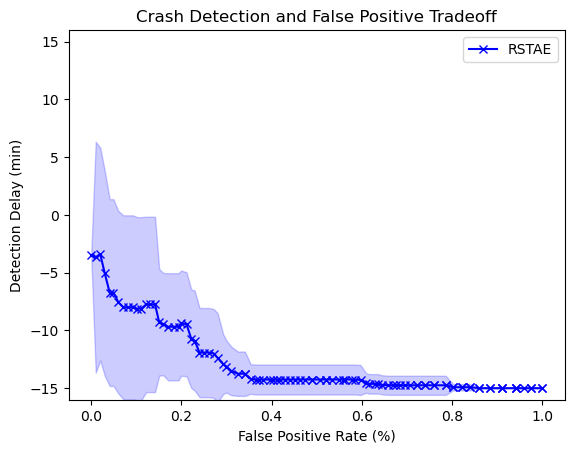

In [22]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] / 2
std_values = delay_df['Std Delay'] / 2

plt.plot(x_values, y_values, color='blue', label='RSTAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [23]:
discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

100%|██████████| 1000/1000 [00:29<00:00, 34.39it/s]

Found FPR of 0.010025062656641603 for 0.01
Found FPR of 0.02506265664160401 for 0.025
Found FPR of 0.04928989139515455 for 0.05
Found FPR of 0.09816207184628237 for 0.1
Found FPR of 0.19924812030075187 for 0.2
FPR 1% gives mean delay of -3.6666666666666665 +/- 9.998611014647096 while missing 0.5%.
FPR 2.5% gives mean delay of -4.555555555555555 +/- 9.502761132207969 while missing 0.25%.
FPR 5% gives mean delay of -6.722222222222222 +/- 8.086721321301672 while missing 0.25%.
FPR 10% gives mean delay of -8.11111111111111 +/- 7.922463764433728 while missing 0.25%.
FPR 20% gives mean delay of -9.375 +/- 4.555788442556715 while missing 0.0%.


### Compute AUC

In [18]:
calculate_auc(test_errors, anomaly_labels)

0.6998595818040263

### Copmute Detection Delay Histogram on Full Dataset

In [25]:
_, _, full_data = get_full_data()
full_data = normalize_data(full_data)
full_data = label_anomalies(full_data)

In [26]:
full_sequence, kept_full_indices = sequence_rstae(full_data, training_params.timesteps, hide_anomalies=False)

  0%|          | 0/18230 [00:00<?, ?it/s]

100%|██████████| 18230/18230 [06:26<00:00, 47.12it/s]


In [27]:
full_errors, _, _ = test_rstae(full_sequence, mse_weights, ae)

In [28]:
full_anomalies = generate_anomaly_labels(full_data, kept_full_indices)
crash_reported = full_data['crash_record'].to_numpy()[0::196][kept_full_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [29]:
full_thresholds = find_thresholds(thresh, full_errors, full_anomalies)

100%|██████████| 1000/1000 [01:53<00:00,  8.85it/s]


In [30]:
offset = find_percent(full_thresholds, 10)
full_anomaly_pred = threshold_anomalies(thresh+offset, full_errors)


Found FPR of 0.10055535861987475 for 0.1


In [31]:
delay, found = crash_detection_delay(full_anomaly_pred, crash_reported)

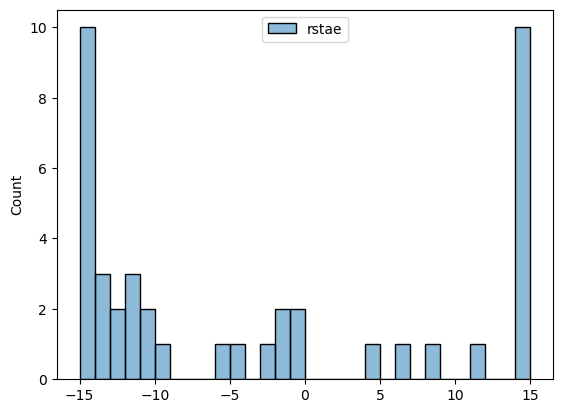

In [32]:
import seaborn as sns 

delay = delay + [30] * (len(found) - np.count_nonzero(found))

sns.histplot(np.array(delay)/2, binwidth=1, alpha=0.5, label='rstae')
plt.legend()

In [33]:
np.save('./saved_results/rstae10delays.npy', np.array(delay)/2)

In [34]:
_, df_clean_test_data, _ = get_full_data()

In [35]:
clean_test_data = normalize_data(df_clean_test_data)
clean_test_data = label_anomalies(clean_test_data)
clean_test_data, kept_test_indices = sequence_rstae(clean_test_data, training_params.timesteps, hide_anomalies=True)

  0%|          | 0/4790 [00:00<?, ?it/s]

100%|██████████| 4790/4790 [00:34<00:00, 137.93it/s]


In [36]:
clean_test_errors, test_recons_speeds, test_true_speeds = test_rstae(clean_test_data, mse_weights, ae)

In [37]:
np.mean(clean_test_errors)

0.009521141

In [38]:
# data = fill_result_df(anomalies_10, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [39]:
# data.to_csv('./saved_results/full_results_test_rstae.csv')

In [40]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# data = pd.read_csv('./saved_results/full_results_test_rstae.csv', index_col=0)
# data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# # plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
# #                             c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed']),marker='s',s=1, cmap='viridis')
# plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [41]:
# from matplotlib.ticker import MultipleLocator

# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 09:30:00')
# end_time = pd.to_datetime('1970-01-01 09:50:00')
# # plt.xlim(start_time, end_time)
# # plt.ylim()

# plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()

In [42]:
# plt.figure(figsize=(16,4), facecolor='white')
# plt.rc('font', family='serif', size=15)
# lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
# plt.gca().invert_yaxis()
# # plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# # Set x-axis limits
# start_time = pd.to_datetime('1970-01-01 08:00:00')
# end_time = pd.to_datetime('1970-01-01 11:00:00')
# # plt.xlim(start_time, end_time)

# # Add vertical line at '1970-01-01 09:39:22'
# vline_time = pd.to_datetime('1970-01-01 09:39:22')
# plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
# plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# # plt.ylim(60,65)
# plt.legend(loc='upper right')
# plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
# plt.xlabel("Time of Day")
# plt.ylabel("Milemarker")
# plt.show()